---
<p style="text-align: center;font-size: 2em;font-weight: bold;">
Projet numérique de Probabilités 2025/26
</p>

---


# Introduction

On va s'intéresser à la simulation de champs aléatoires gaussiens. On peut définir un champ aléatoire Gaussien comme une collection de variables aléatoires indexées par un ensemble telles que toute combinaison linéaire finie de ces variables aléatoires suit une loi normale. Cette propriété implique que chacune des variables aléatoires associées à un point de $\mathbb{R}^2$ suit elle-même une loi normale (la réciproque est fausse). Pour simplifier, nous nous intéresserons à des champs aléatoires gaussiens définis sur une grille régulière de points dans un domaine  $\mathbb{R}^2$ (comme un plateau de go). 

Un champ aléatoire Gaussien est entièrement caractérisé par son espérance et sa fonction de covariance. 

- La fonction de covariance est une fonction qui associe à deux points (de $\mathbb{R}^2$) la covariance des variables aléatoires associées à chacun des deux points. La fonction de covariance permet d'assurer une certaine cohérence de la distribution des variables aléatoires (exemple du prof d'un champ gaussien : altitude en fonction des coordonées dans $\mathbb{R}^2$). Ici la fonction de covariance fait que deux variables aléatoires associées à des points géographiquement proches auront une grande covariance.

- L'espérance est une fonction qui attribue à chaque point du domaine la valeur moyenne de la variable aléatoire associée à ce point. Comme les variables aléatoires associées à chaque point de $\mathbb{R}^2$ suivent une loi normale, l'espérance est la fonction qui à $x$ dans $\mathbb{R}^2$ renvoie $\mu(x)$ . 

Un exemple classique de fonction de covariance est la fonction exponentielle quadratique (ou gaussienne) définie par :
$$C(x, y) = \sigma^2 \exp\left(-\frac{\|x - y\|^2}{a}\right)$$
où  $\sigma^2$ est la variance,  $a$ est le facteur d'échelle, et $\|x - y\|$ est la distance euclidienne entre les points  $x$ et $y$.
Une telle fonction de covariance implique que les points proches dans le domaine ont des valeurs de champ aléatoire fortement corrélées, tandis que les points éloignés ont des valeurs faiblement corrélées. Elle est souvent utilisée pour modéliser des phénomènes naturels où la corrélation diminue avec la distance. 

Dans ce projet, nous allons implémenter une méthode pour simuler des champs aléatoires gaussiens sur une grille régulière de points dans un domaine  $\mathbb{R}^2$. Nous utiliserons dans un premier temps la méthode de la décomposition de Cholesky pour générer des échantillons de champs aléatoires gaussiens à partir de leur fonction de covariance. Dans un second temps, nous explorerons un méthode plus efficace basée sur la représentation spectrale de la fonction de covariance. Enfin, nous verrons comment conditionner ces simulations sur des observations ponctuelles.

# Simulation par la méthode de Cholesky

Quitte à réarranger les points de la grille, on peut supposer que l'on a une liste finie de points  $x_1, x_2, \ldots, x_n$ dans  $\mathbb{R}^2$ où l'on souhaite simuler le champ aléatoire Gaussien. On note $X_i$ la variable aléatoire associée au point $x_i$ de $\mathbb{R}^2$. 
La fonction de répartition est une simple reformulation de ce qu'on connait déjà : 
$$C(x_i, x_j) = Cov(X_i, X_j)$$
On travaille alors avec une fonction qui prend comme paramètres des vecteurs de $\mathbb{R}^2$ plutôt que des variables aléatoires $X_i, X_j$

On construit la matrice de covariance $K$ :

$$K_{ij} = C(x_i, x_j)$$



On va implementer la méthode de Cholesky pour générer des réalisations de champs aléatoires gaussiens à partir de cette matrice de covariance.

1. Ecrire une fonction "covariance_gaussienne" qui prend en entrée une matrice de distances, ainsi que les paramètres  $\sigma^2$ et  $a$, et qui retourne la valeur de la fonction de covariance gaussienne entre ces deux points.

In [2]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

In [34]:


np.random.seed(12345)
#la matrice de distances en entrée elle est n-n ?
def covariance_gaussienne(D,sigma_carré,a):
    b,c=np.shape(D)
    K=[[0 for j in range(c)]for i in range(b)]
    for i in range(b):
        for j in range(c):
            K[i][j]=sigma_carré*np.exp(-((D[i][j])**2)/a)
    return K
#test : 
D=[[2,6],[3,5]]
sigma_carré=1
a=1
C=covariance_gaussienne(D,sigma_carré,a)
print(C)

[[np.float64(0.01831563888873418), np.float64(2.3195228302435696e-16)], [np.float64(0.00012340980408667956), np.float64(1.3887943864964021e-11)]]


2. Discrétiser le domaine  $[0, 1] \times [0, 1]$ en une grille régulière de  $n \times n$ points (par exemple,  $n = 50$). Construire la matrice de distances entre tous les points de la grille.

In [5]:
n=50
x=np.linspace(0,1,n)
y=np.linspace(0,1,n)
X,Y=np.meshgrid(x,y)                             #2 fonctions issues de la biblio qui permettent de former une liste de points
points = np.column_stack((X.ravel(), Y.ravel())) #on veut tout stocker dans une liste de taille n carré

#construction de la matrice de distances
def distance(points):
    N=len(points)
    D=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
             D[i][j] = np.linalg.norm(points[i] - points[j])
            #D[i][j]=abs(x[i]-y[j]) mauvaise définition de la norme, ici entre deux points donc entre 2 doublets
    return D

#test 
b=distance(points)
print(b)

[[0.         0.02040816 0.04081633 ... 1.38565267 1.3998572  1.41421356]
 [0.02040816 0.         0.02040816 ... 1.3716047  1.38565267 1.3998572 ]
 [0.04081633 0.02040816 0.         ... 1.35771815 1.3716047  1.38565267]
 ...
 [1.38565267 1.3716047  1.35771815 ... 0.         0.02040816 0.04081633]
 [1.3998572  1.38565267 1.3716047  ... 0.02040816 0.         0.02040816]
 [1.41421356 1.3998572  1.38565267 ... 0.04081633 0.02040816 0.        ]]


3. Utiliser la fonction "covariance_gaussienne" pour construire la matrice de covariance $K$ en évaluant la fonction de covariance pour chaque paire de points dans la grille puis calculer la décomposition de Cholesky de $K$ (voir *np.linalg.cholesky*).

On choisira ici  $\sigma^2 = 1$ et  $a = 0.05$.

NB : Pour assurer la stabilité numérique, on peut ajouter un petit terme de régularisation à la diagonale de la matrice de covariance avant de calculer la décomposition de Cholesky (par exemple,  $10^{-10} I$ où  $I$ est la matrice identité).

In [ ]:
sigma2 = 1.0
a = 0.05


K=covariance_gaussienne(distance(points),sigma2,a)
for i in range(len(K)):
    K[i][i]+=10**(-10)

  
décomp_cholesky=np.linalg.cholesky(K) #triangulaire inférieure par défaut

In [28]:
print(np.size([[1,0],[2,3],[2,6]]))

6


4. Générer et représenter une réalisation du champ aléatoire Gaussien centré et de covariance $K$.

(2500, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

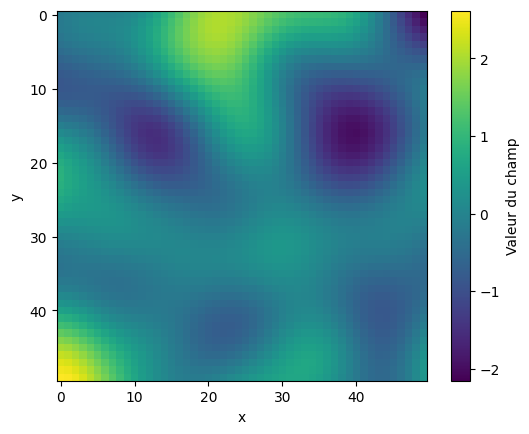

In [ ]:
A=np.random.normal(loc=0,scale=1,size=(n*n,1))
Z=np.dot(décomp_cholesky,A)

Z_affichage=Z.reshape(len(x),len(y)) #on a calculé avec Z de taille n carré et on veut retrouver une matrice nxn

plt.imshow(Z_affichage)
plt.colorbar(label="Valeur du champ")
plt.xlabel("x")
plt.ylabel("y")
plt.show

5. Essayer d'augmenter le nombre de pas de discrétisation. Que remarquez-vous ? Expliquer pourquoi.

Si on augmente le nombre de pas, la complexité devient trop grande pour l'ordinateur qui ne peut plus exécuter le programme.

# Simulation par la méthode spectrale 

Vu les limitations de la méthode de Cholesky pour des grilles fines, nous allons explorer une méthode alternative basée sur la représentation spectrale de la fonction de covariance. 

1. Soit $C(h) = \exp\left(-\frac{\|h\|^2}{a}\right)$, où $h \in \mathbb{R}^2$. Montrer que :
$$ C(h) = \int_{\mathbb{R}^2} \cos(\langle w, h \rangle) \frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right) dw $$

NB: on pourra s'inspirer du calcul de la fonction caractéristique d’un vecteur gaussien en annexe du chapitre IV du cours.

2. Soient $W$ et $\Phi$ deux variables aléatoires indépendantes, de lois respectives $\mathcal{N}(0, \frac{2}{a} I_2)$, avec $I_2$ la matrice identité de dimension 2, et $\mathcal{U}[0, 2\pi[$. Montrer que la variable aléatoire définie en tout point $x \in \mathbb{R}^2$ par :
$$ Z(x) = \sqrt{2} \cos(\langle W, x \rangle + \Phi) $$
est d'espérance nulle et de fonction de covariance $C$.

3. Soient les suites de variables aléatoires indépendantes $(W_n)_{n \in \mathbb{N}}$ et $(\Phi_n)_{n \in \mathbb{N}}$ telles que $W_n \sim \mathcal{N}(0, \frac{2}{a} I_2)$ et $\Phi_n \sim \mathcal{U}([0, 2\pi])$. Montrer que pour tout ensemble fini de points  $x_1, \ldots, x_n$ dans  $\mathbb{R}^2$ , le vecteur aléatoire $Y = (Y(x_1), \ldots, Y(x_n))$ où :
$$ Y(x_i) = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \cos(\langle W_k, x_i \rangle + \Phi_k) $$
tend vers un vecteur aléatoire de loi normale multivariée d'espérance nulle et de matrice de covariance $K$ définie par  $K_{ij} = C(x_i - x_j)$.

4. Implémenter une fonction basée sur cette méthode pour simuler un champ aléatoire gaussien sur une grille régulière de points dans le domaine  $[0, 1] \times [0, 1]$. Cette fonction prendra en entrée les coordonnées des points de la grille, $a$ et  $N$ et retournera une réalisation du champ aléatoire gaussien simulé.

5. Tester cette fonction pour différentes valeurs du nombre de points de discrétisation et de $N$. Proposer un diagnostic permettant de calibrer $N$ afin que les résultats soient conformes aux attentes. Comparer les résultats obtenus avec ceux de la méthode de Cholesky. Quels sont les avantages et les inconvénients de chaque méthode ?

In [3]:
sigma2 = 1.0
a = 0.05


# Simulation conditionnelle 

On suppose désormais que l'on dispose de valeurs observées du champ aléatoire Gaussien en certains points du domaine. On souhaite simuler des réalisations conditionnelles du champ aléatoire Gaussien en tenant compte de ces observations. On travaillera désormais avec une grille de taille $100 \times 100$.
Soit $X$ un vecteur aléatoire Gaussien partitionné en deux sous-vecteurs $X_1$ et $X_2$, où $X_1$ représente les points observés et $X_2$ les points non observés. 

1. Rappeler l'expression de la distribution jointe de $X = (X_1, X_2)$ puis de la distribution conditionnelle de $X_2$ sachant $X_1$. Montrer que la différence entre l'espérance conditionnelle et le vecteur des points non observés est un vecteur Gaussien d'espérance nulle indépendant du vecteur des points non observés.

Je ne suis pas certaine d'avoir compris la question mais on a la formule suivante pour tout boréliens B1 et B2:

$\mathbb{P}(X_1 \in B_1, X_2 \in B_2)=\displaystyle\int_{B1} \mathbb{P}_{X_2|X_1=x_1}(B_2)d\mathbb{P}_{X_1}(X1)$


Pour la distribution conditionnelle,
ATTENTION A COMPL2TER

On veut montrer que la formule suivante est vraie : E(X2|X1)=X2+ G où G est un vecteur gaussien indépendant.

Montrons que E((E(X2|X1)-X2)|)=0 pour montrer que G est d'espérance nulle et indépendant de X1 (car ce n'es pas indépendant de X2).Montrons que la covariance est nulle, pour des vecteurs gaussiens cela prouvera l'indépendance.
Cov(E(X2|X1)-X2,X1)= Cov(E(X2)+C21*C1*(X1-E(X1))-X2,X1)=0
De plus E(E(X2|X1)-X2)=E(X2)-E(X2)=0. L'espérance de G vaut bien 0.


On va donc chercher à simuler directement cette différence pour obtenir des réalisations conditionnelles du champ aléatoire Gaussien.

2. Générer 50 points uniformément répartis dans le domaine  $[0, 1] \times [0, 1]$ et simuler des observations du champ aléatoire Gaussien en ces points.


On réutilise la simulation de la partie I(Simulation par Cholesky) pour générer 2500 points et simuler l'observation  de 50 de ces points (on fera comme si l'on ne connaissait pas les autres points)

In [22]:
n=50
x=np.linspace(0,1,n)
y=np.linspace(0,1,n)
X,Y=np.meshgrid(x,y)                             #2 fonctions issues de la biblio qui permettent de former une liste de points
points = np.column_stack((X.ravel(), Y.ravel())) #on veut tout stocker dans une liste de taille n carré

K=covariance_gaussienne(distance(points),sigma2,a)
for i in range(len(K)):
    K[i][i]+=10**(-10)          #comme on utilise déjà la matrice de covariance, faut il déjà raouter 10**(-2) ?

A=np.random.normal(loc=0,scale=1,size=(n*n,1))
Z=np.dot(décomp_cholesky,A)
Z_affichage=Z.reshape(len(x),len(y)) 

#on veut récupérer 50 points répartis uniformément : c'est à dire répartis régulièrement ou selon une loi uniforme ? Je pars sur la loi uniforme
points_observés=np.random.choice(range(2500), 50, replace = False) #uniforme
liste_observations=[]
for i in points_observés:
    liste_observations.append(Z[i]) #la liste des observations des points que l'on a choisi

#On a donc X1=coordonées des point observés
#On va construire la liste de X2=coordonées des points non observés
points_non_observés=[]
for j in range(2500):
    if j not in points_observés:
        points_non_observés.append(j)

C_p_o=[[a%n,a//n] for a in points_observés]
C_p_no=[[a%n,a//n] for a in points_non_observés]



3. Calculer l'espérance conditionnelle aux points de la grille et la représenter.

NB : Pour assurer la stabilité numérique, on doit ajouter un terme de régularisation plus important à la diagonale de la matrice de covariance avant de calculer son inverse ($10^{-2} I$ conviendra ici).

On utilise cette formule avec les espérances nulles
E(X2|X1)=E(X2)+Cov(X2,X1)(Cov(X1,X1)**(-1))*(X1-E(X1))
Donc E(X2|X1)=Cov(X2,X1)(Cov(X1,X1)**(-1))*(X1)
On doit calculer les matrices de distance pour X1 et X1, X2 et X1.

In [39]:
sigma2 = 1.0
a = 0.05

B=distance_matrix(C_p_o,C_p_o,2)
C=distance_matrix(C_p_no,C_p_o,2)

K_X1_X1=covariance_gaussienne(B,sigma2,a)
K_X1_X2=covariance_gaussienne(C,sigma2,a)

K11=K_X1_X1+10*(-2)*np.eye(len(K_X1_X1))
K12=K_X1_X2
K11_1=np.linalg.inv(K11)


On applique maintenant la formule définie précédemment.

In [54]:
prod_1=np.dot(K11_1,liste_observations) #sous produit
Esp=np.dot(K12,prod_1)

B=np.copy(Z)            #on copie la matrice des observations pour la modifier et l'afficher
print(np.shape(Esp))
print(np.shape(C_p_no))

j=0
for i in points_non_observés:
    B[i]=Esp[j][0]
    j+=1

print(np.shape((B)))

(2450, 1)
(2450, 2)
(2500, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

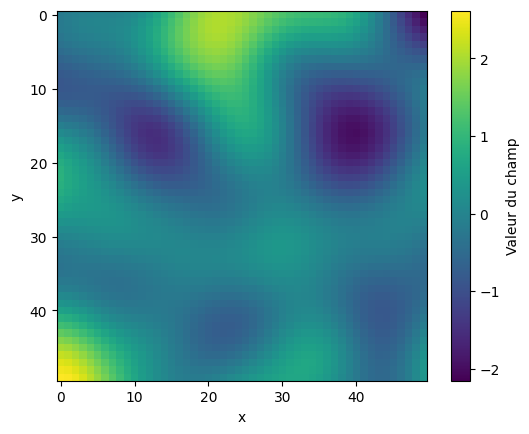

In [55]:
Esp_affichage=B.reshape(len(x),len(y)) #on a calculé avec Z de taille n carré et on veut retrouver une matrice nxn

plt.imshow(Z_affichage)
plt.colorbar(label="Valeur du champ")
plt.xlabel("x")
plt.ylabel("y")
plt.show

4. Pour générer de manière indépendante la différence entre l'espérance conditionnelle et le vecteur des points non observés, on génère une seconde réalisation du champ aléatoire aux points de la grille **et** aux coordonnées des points observés par la méthode spectrale. On calcule ensuite la différence entre cette réalisation et l'espérance conditionnelle sachant les valeurs simulées aux coordonnées des points observés. Enfin, on additionne cette différence à l'espérance conditionnelle sachant les observations pour obtenir une réalisation conditionnelle du champ aléatoire Gaussien sur la grille. Implémenter cette approche et représenter une réalisation conditionnelle du champ aléatoire Gaussien sur la grille.

5. Générer 500 simulations conditionnelles et comparer la moyenne empirique de ces simulations avec l'espérance conditionnelle calculée précédemment. Que constate-t-on ? Expliquer pourquoi.

# Simulation non-stationnaire

On souhaite désormais simuler un champ aléatoire Gaussien non-stationnaire, c'est-à-dire dont la fonction de covariance dépend de la position dans le domaine. Ces modèles plus complexes offrent une plus grande flexibilité pour modéliser des phénomènes naturels. En particulier, on va chercher à faire varier la valeur du paramètre d'échelle $a$ en fonction de la position. On considère une fonction de covariance de la forme :
$$C(x, y) = 2\frac{\sqrt{a(x) a(y)}}{a(x)+a(y)} \exp\left(-\frac{2\|x - y\|^2}{a(x)+a(y)}\right),$$
où $a : [0,1]^2 \to \mathbb{R}_+^*$ est une fonction définissant le paramètre d'échelle en chaque point du domaine.

Pour générer des réalisations de ce champ aléatoire non-stationnaire, on peut adapter la méthode spectrale en utilisant une approche locale. Précisément, on va considérer la modification suivante de la méthode spectrale :

$$Z(x) = \sqrt{\frac{2f_x(W)}{g(W)}}\cos(\langle W, x \rangle + \Phi)$$

où $W$ et $\Phi$ sont deux variables aléatoires indépendantes, de lois respectives $\mathcal{N}(0, \frac{2}{a} I_2)$ et $\mathcal{U}[0, 2\pi[$, et où $f_x$ est la densité de la loi $\mathcal{N}(0, \frac{2}{a(x)} I_2)$ et $g$ est la densité de la loi $\mathcal{N}(0, \frac{2}{a} I_2)$ pour $a = \inf_{x \in [0,1]^2} a(x)>0$, avec $a>0$.

1. Justifier que cette modification permet de simuler un champ aléatoire Gaussien non-stationnaire avec la fonction de covariance donnée précédemment. Quelle technique de simulation vue en cours est-elle utilisée ici ?

2. Implémenter cette méthode pour simuler un champ aléatoire Gaussien non-stationnaire sur une grille régulière de points dans le domaine  $[0, 1] \times [0, 1]$. On choisira, par exemple, une fonction $a(x)$ variant linéairement selon l'axe des ordonnées entre deux valeurs $a_{min}=0.01$ et $a_{max}=0.1$ sur le domaine. Commenter les résultats obtenus.